In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings
import optuna

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

In [4]:
train.head(10).T

id,0,1,2,3,4,5,6,7,8,9
MonsoonIntensity,5.000,6.00,6.00,3.000,5.000,5.00,8.00,6.000,5.000,4.000
TopographyDrainage,8.000,7.00,5.00,4.000,3.000,4.00,3.00,6.000,2.000,2.000
RiverManagement,5.000,4.00,6.00,6.000,2.000,1.00,1.00,5.000,8.000,3.000
Deforestation,8.000,4.00,7.00,5.000,6.000,4.00,2.00,7.000,5.000,5.000
Urbanization,6.000,8.00,3.00,4.000,4.000,2.00,3.00,5.000,4.000,8.000
ClimateChange,4.000,8.00,7.00,8.000,4.000,4.00,7.00,5.000,5.000,6.000
DamsQuality,4.000,3.00,1.00,4.000,3.000,6.00,3.00,3.000,2.000,5.000
Siltation,3.000,5.00,5.00,7.000,3.000,6.00,4.00,5.000,4.000,5.000
AgriculturalPractices,3.000,4.00,4.00,6.000,3.000,7.00,6.00,5.000,5.000,7.000
Encroachments,4.000,6.00,5.00,8.000,3.000,5.00,7.00,5.000,5.000,6.000


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


# Preprocessing
- Using sum feature suggested by @ambrosm [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274)
- Sorting features as suggested by @siukeitin [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579)
- Adding a few other statistical features which have been suggested on the forums by various people

In [6]:
def add_stat_features(dataframe, cols, unique_vals):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe["_sum_log"] = np.log1p(dataframe["_sum"])
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_median'] = dataframe[cols].median(1)
    dataframe['_max'] = dataframe[cols].max(1)
    dataframe['_min'] = dataframe[cols].min(1)
    dataframe['_var'] = dataframe[cols].var(1)
    dataframe['_std'] = dataframe[cols].std(1)
    dataframe['_mode'] = dataframe[cols].mode(1)[0]
    dataframe['_skew'] = dataframe[cols].skew(axis=1)
    dataframe['_kurtosis'] = dataframe[cols].kurtosis(axis=1)
    dataframe['_25th'] = dataframe[cols].quantile(0.25, axis=1)
    dataframe['_75th'] = dataframe[cols].quantile(0.75, axis=1)
    dataframe['_hmean'] = len(cols) / dataframe[cols].apply(lambda x: (1/x).mean(), axis=1)
    dataframe['_gmean'] = dataframe[cols].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    dataframe['_2nd_moment'] = dataframe[cols].apply(lambda x: (x**2).mean(), axis=1)
    dataframe['_3rd_moment'] = dataframe[cols].apply(lambda x: (x**3).mean(), axis=1)
    dataframe['_entropy'] = dataframe[cols].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    dataframe['_special1'] = dataframe['_sum'].isin(np.arange(72, 76))
    
    sorted_features = [f"_sort_{i}" for i in np.arange(len(cols))]
    dataframe[sorted_features] = np.sort(dataframe[cols], axis=1)
    
    for i in range(10, 100, 10):
        dataframe[f'_{i}th'] = dataframe[cols].quantile(i/100, axis=1)

    for v in unique_vals:
        dataframe['_cnt{}'.format(v)] = (dataframe[cols] == v).sum(axis=1)

    return dataframe
        
feature_cols = list(test.columns)
target_col = 'FloodProbability'

In [7]:
unique_vals = []
for df in [train, test]:
    for col in feature_cols:
        unique_vals += list(df[col].unique())
unique_vals = list(set(unique_vals))

In [8]:
train = add_stat_features(train, feature_cols, unique_vals)
test = add_stat_features(test, feature_cols, unique_vals)

# train = train.drop(feature_cols, axis=1)
# test = test.drop(feature_cols, axis=1)

X = train.drop(target_col, axis=1)
y = train[target_col]

# Training

In [9]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [10]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 15,
    'max_leaves': 51,
    'n_estimators': 921,
    'random_state': SEED,
    'objective': 'reg:gamma',
    'grow_policy': 'depthwise',
    'gamma': 0.001191175583365525,
    'reg_alpha': 0.4922409840555407,
    'subsample': 0.9043911969552909,
    'reg_lambda': 0.2006103666827618,
    'max_delta_step': 0.5187236006765079,
    'learning_rate': 0.031068537109748533,
    'colsample_bynode': 0.9056076202576685,
    'min_child_weight': 0.1519636306480494,
    'colsample_bytree': 0.8136171314595549,
    'colsample_bylevel': 0.8469915838866402,
}

cb_params = {
    'depth': 10,
    'verbose': False,
    'iterations': 1566,
    'random_state': SEED,
    'min_data_in_leaf': 17,
    'loss_function': 'RMSE',
    'bootstrap_type': 'MVS',
    'grow_policy': 'SymmetricTree',
    'l2_leaf_reg': 1.6916966756596432,
    'learning_rate': 0.02548238769955287,
    'colsample_bylevel': 0.9626458989963868,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 222,
    'num_leaves': 222,
    'n_estimators': 702,
    'subsample_freq': 7,
    'random_state': SEED,
    'boosting_type': 'gbdt',
    'min_child_samples': 80,
    'subsample': 0.6815709181423294,
    'reg_lambda': 0.00539368681254854,
    'reg_alpha': 0.017697331864994163,
    'learning_rate': 0.02089310186842622,
    'colsample_bytree': 0.4920417554994534,
    'min_child_weight': 0.021791620166345272
}

In [11]:
xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds = Trainer(xgb_model, X, y).fit()
print(f'{xgb_model.__class__.__name__}: {np.mean(xgb_scores):.6f} ± {np.std(xgb_scores):.6f}')

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds = Trainer(cb_model, X, y).fit()
print(f'{cb_model.__class__.__name__}: {np.mean(cb_scores):.6f} ± {np.std(cb_scores):.6f}')

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds = Trainer(lgbm_model, X, y).fit()
print(f'{lgbm_model.__class__.__name__}: {np.mean(lgbm_scores):.6f} ± {np.std(lgbm_scores):.6f}')

XGBRegressor: 0.869156 ± 0.000382
CatBoostRegressor: 0.869119 ± 0.000395
LGBMRegressor: 0.869174 ± 0.000391


In [12]:
ridge_x = np.column_stack([xgb_oof_preds, cb_oof_preds, lgbm_oof_preds])

scaler = StandardScaler()
ridge_x = pd.DataFrame(scaler.fit_transform(ridge_x))

ridge_model = Ridge(positive=True, tol=1e-6)
ridge_model.fit(ridge_x, y)
ridge_preds = ridge_model.predict(ridge_x)
ridge_score = r2_score(y, ridge_preds)
print(f'{ridge_model.__class__.__name__}: {ridge_score:.6f}')

Ridge: 0.869289


In [13]:
weights = pd.Series(ridge_model.coef_, index=["XGBRegressor", "CatBoostRegressor", "LGBMRegressor"])
weights

XGBRegressor         0.012115
CatBoostRegressor    0.013220
LGBMRegressor        0.022243
dtype: float64

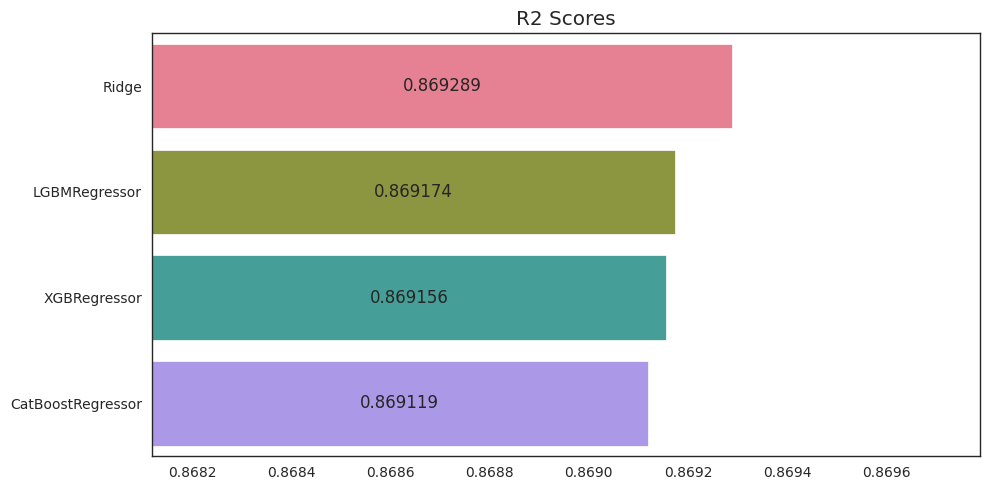

In [14]:
sns.set_style("white")
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    cb_model.__class__.__name__: cb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    ridge_model.__class__.__name__: np.array([ridge_score] * 5)
})
scores = scores[scores.mean().sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')
ax.set_title('R2 Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.0005)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
model_preds = {
    xgb_model.__class__.__name__: xgb_oof_preds,
    cb_model.__class__.__name__: cb_oof_preds,
    lgbm_model.__class__.__name__: lgbm_oof_preds,
    ridge_model.__class__.__name__: ridge_preds
}

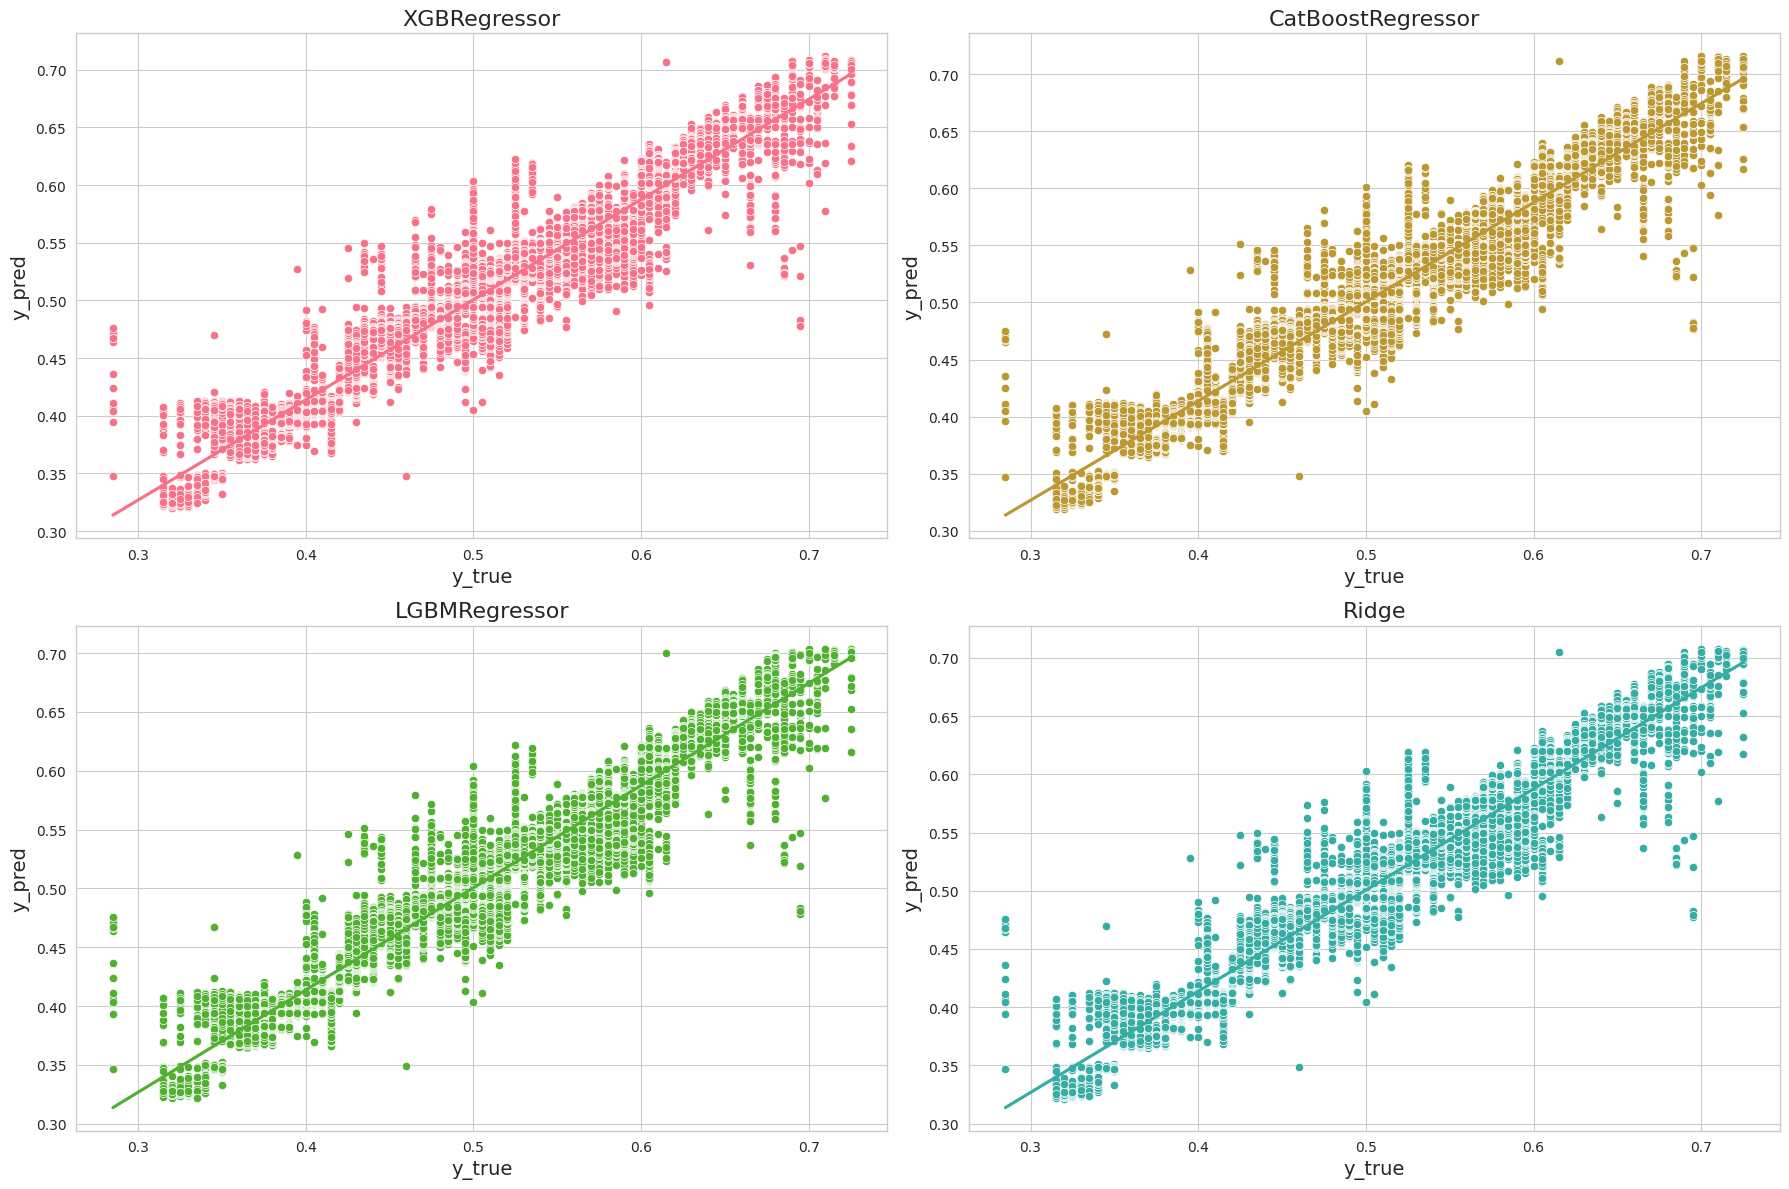

In [16]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.scatterplot(x=y, y=preds, ax=ax, color=sns.color_palette("husl")[i])
    sns.regplot(x=y, y=preds, ax=ax, scatter=False, color=sns.color_palette("husl")[i])
    
    ax.set_xlabel('y_true', fontsize=14)
    ax.set_ylabel('y_pred', fontsize=14)
    ax.set_title(model, fontsize=16)

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

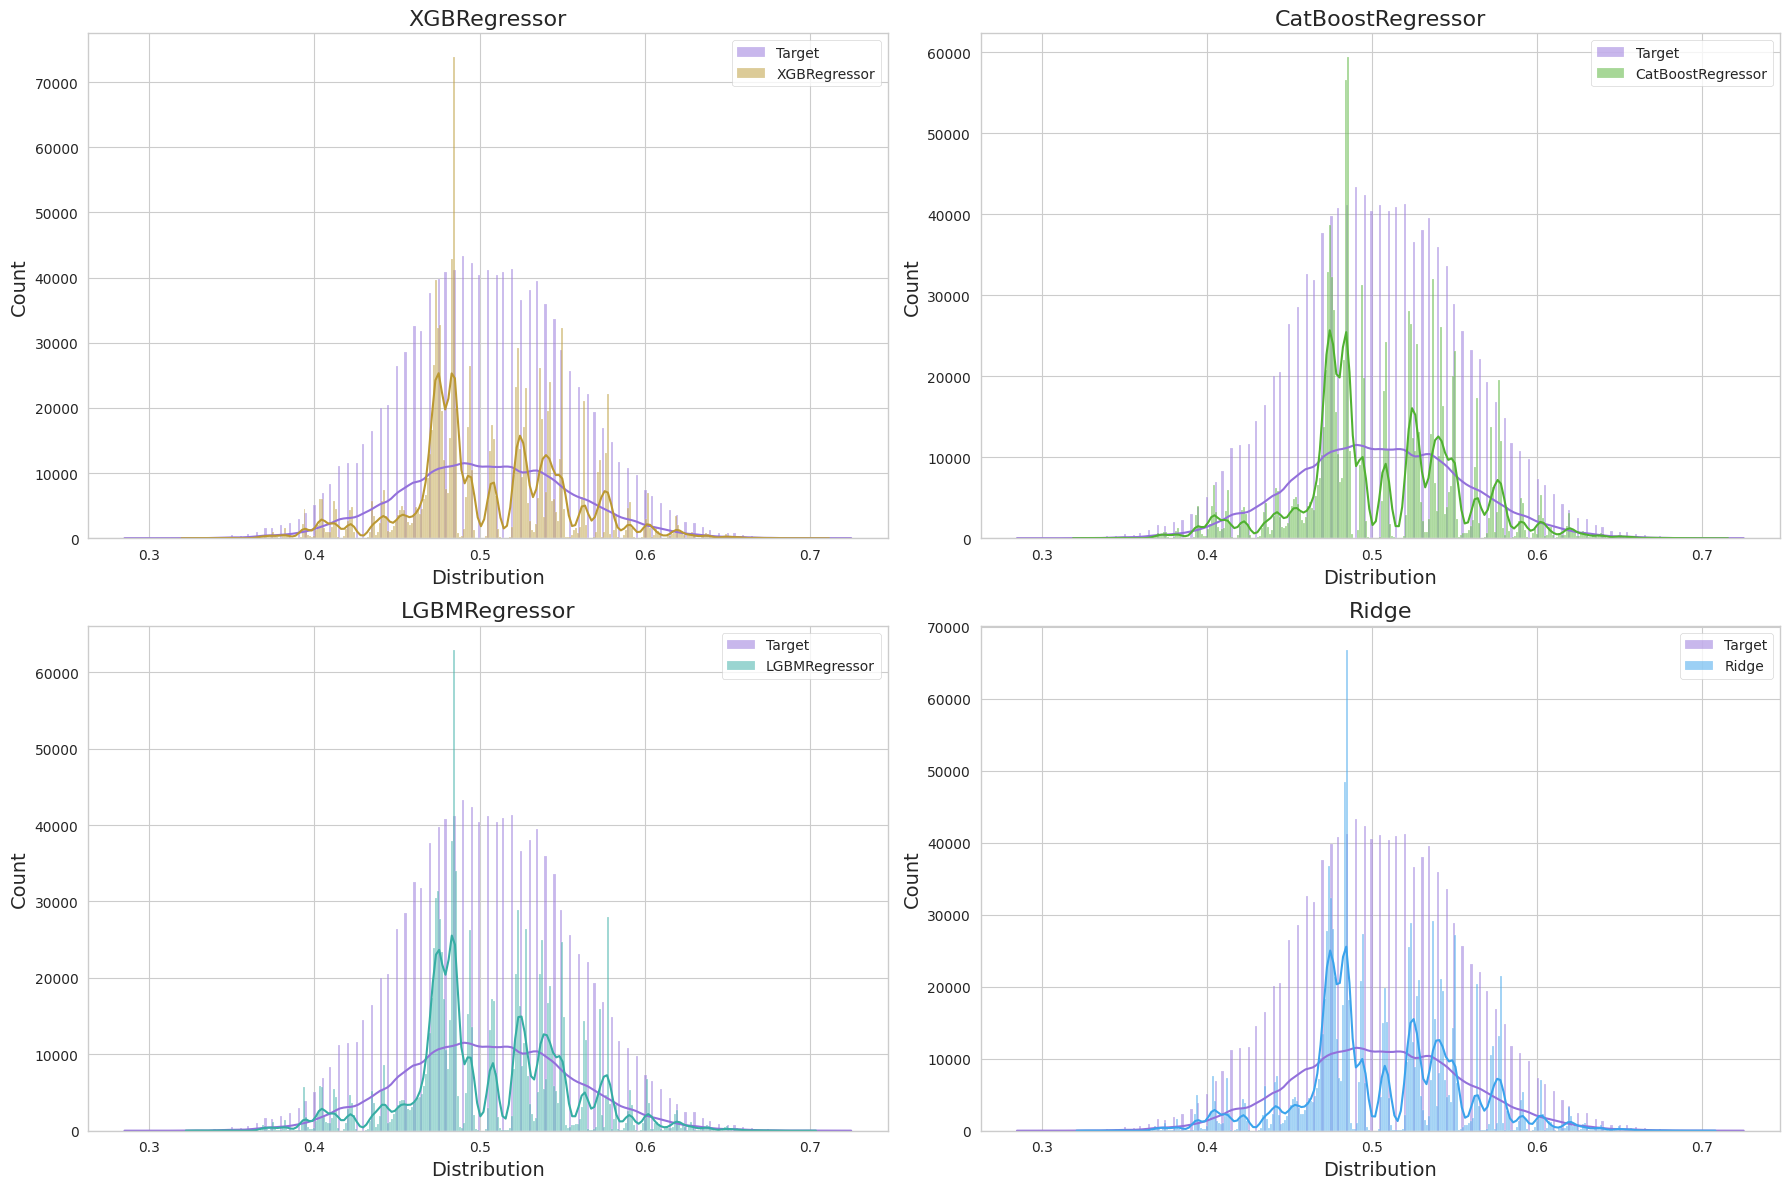

In [17]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.histplot(data=y, ax=ax, color='#9370DB', kde=True, legend=True, label="Target")
    sns.histplot(data=preds, ax=ax, color=sns.color_palette("husl")[i+1], kde=True, legend=True, label=model)
    
    ax.set_xlabel('Distribution', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(model, fontsize=16)
    ax.legend()

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Making Predictions

In [18]:
ridge_x_test = np.column_stack([
    Trainer(xgb_model, X, y).predict(test), 
    Trainer(cb_model, X, y).predict(test),
    Trainer(lgbm_model, X, y).predict(test), 
])
scaler = StandardScaler()
ridge_x_test = pd.DataFrame(scaler.fit_transform(ridge_x_test))

In [19]:
y_pred = ridge_model.predict(ridge_x_test)
submission = pd.DataFrame({'id': test.index, target_col: y_pred})
submission.to_csv(f'ensemble.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577665
1,1117958,0.456151
2,1117959,0.447137
3,1117960,0.466490
4,1117961,0.466635
